In [1]:
from fastai.vision.all import *
from torchsummary import summary

In [2]:
# Using device 2 to avoid other users on the server
torch.cuda.set_device(2)
default_device()

device(type='cuda', index=2)

# Data Processing

1. Copy files from local box folder to the server (and convert HEIC)

```bash
# From local machine
mogrify -monitor -format jpg FrankOrFrary/**/*.HEIC
find FrankOrFrary -name "*.HEIC" -print0 | xargs -0 rm -rf
rsync -aivP FrankOrFrary dgx01:/data/cs152/
```

2. Convert file types (e.g., HEIC)

```bash
!/usr/bin/env bash

# Set options for recurisve glob
shopt -s globstar nullglob

RAW_DATASET_PATH=/data/cs152/FrankOrFrary/raw
PROCESSED_DATASET_PATH=/data/cs152/FrankOrFrary/processed

# Loop over all images in the raw dataset
for image_to_convert in "$RAW_DATASET_PATH"/**/*; do
    # Skip directories
    if [[ -d "$image_to_convert" ]]; then continue; fi

    # Get the file name and replace extension with jpg
    image_name=$(basename "$image_to_convert")
    image_name="${image_name%.*}.jpg"

    # Ensure the output directory exists
    parent_name=$(basename "$(dirname "$image_to_convert")")
    mkdir -p "$PROCESSED_DATASET_PATH"/"$parent_name"

    # Create the new image name
    image_name="$PROCESSED_DATASET_PATH"/"$parent_name"/"$image_name"

    # Create the new image if it doesn't exist
    if [[ -f "$image_name" ]]; then
        echo "$image_name" already exists
    else
        echo "Creating $image_name"
        convert "$image_to_convert" -strip -thumbnail '1000>' -format jpg "$image_name"
    fi
done

```


Some issues:

```text
convert: Invalid SOS parameters for sequential JPEG `/data/cs152/FrankOrFrary/raw/Frary/Alan-Frary-15.jpg' @ warning/jpeg.c/JPEGWarningHandler/403.

convert: no decode delegate for this image format `HEIC' @ error/constitute.c/ReadImage/746.
convert: no images defined `/data/cs152/FrankOrFrary/processed/Frary/Aldo-frary-03.jpg' @ error/convert.c/ConvertImageCommand/3342.
```

In [3]:
path = Path("/data/cs152/FrankOrFrary/processed")
path.ls()

(#3) [Path('/data/cs152/FrankOrFrary/processed/models'),Path('/data/cs152/FrankOrFrary/processed/Frary'),Path('/data/cs152/FrankOrFrary/processed/Frank')]

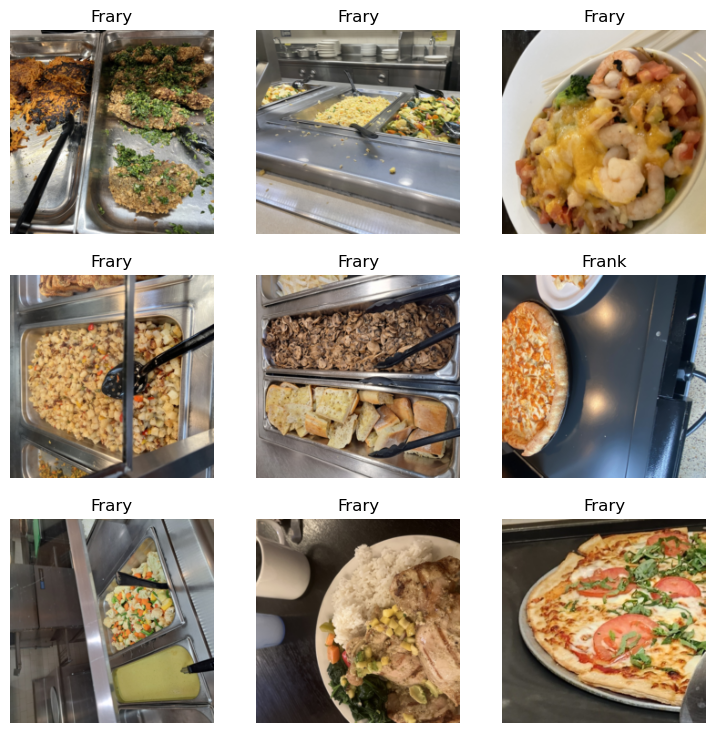

In [4]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224), num_workers=16)
dls.show_batch()
# file <filename> on invalid files

In [5]:
print("Validation dataset size:", len(dls.valid_ds))
print("Training dataset size:", len(dls.train_ds))

Validation dataset size: 176
Training dataset size: 707


In [6]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
summary(learn.model);

/opt/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              (73,984)
|    |    └─BasicBlock: 3-2              (73,984)
|    |    └─BasicBlock: 3-3              (73,984)
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              (230,144)
|    |    └─BasicBlock: 3-5              (295,424)
|    |    └─BasicBlock: 3-6              (295,424)
|    |    └─BasicBlock: 3-7              (295,424)
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              (919,040)
|    |    └─BasicBlock: 3-9              (1,180,672)
|    |    └─BasicBlock: 3-10             (1,180,672)
|    |    └─BasicBlock: 3-11             (1,180,672)
|    |    └─BasicBlock: 3-12 

SuggestedLRs(valley=0.0020892962347716093)

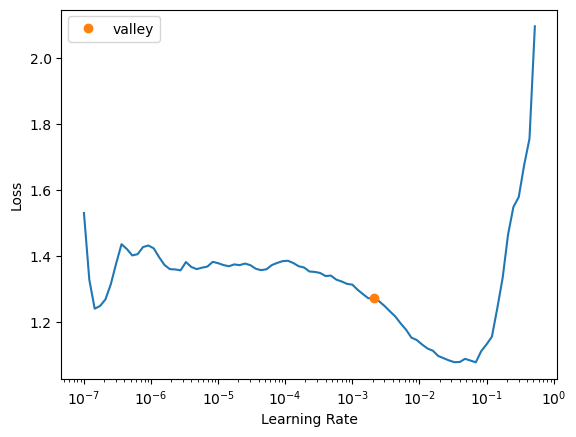

In [7]:
learn.lr_find()

In [8]:
learn.fine_tune(4, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.235416,1.191931,0.664773,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.967448,1.134969,0.664773,00:18
1,0.733293,1.273963,0.704545,00:18
2,0.565732,1.097633,0.738636,00:18
3,0.436872,1.006803,0.767045,00:18


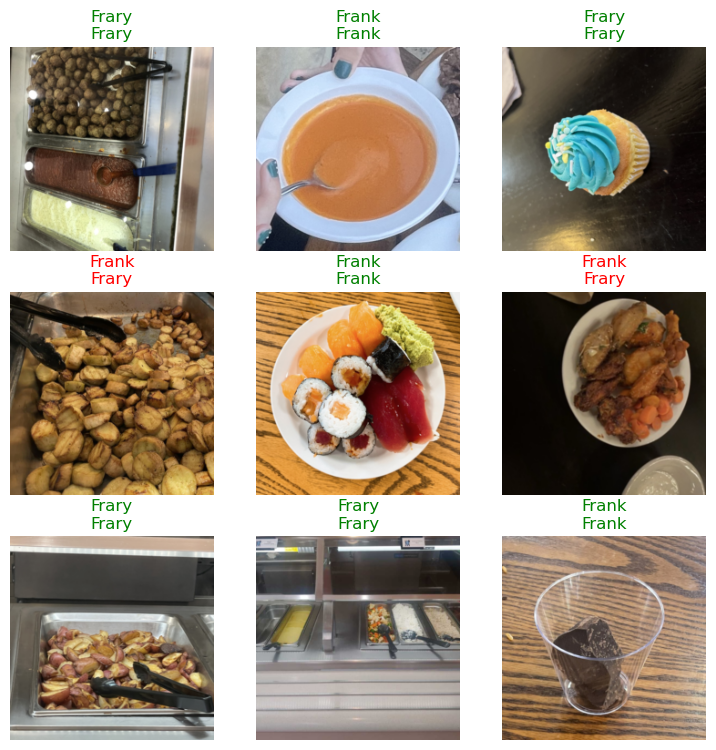

In [9]:
learn.show_results()

In [10]:
# interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

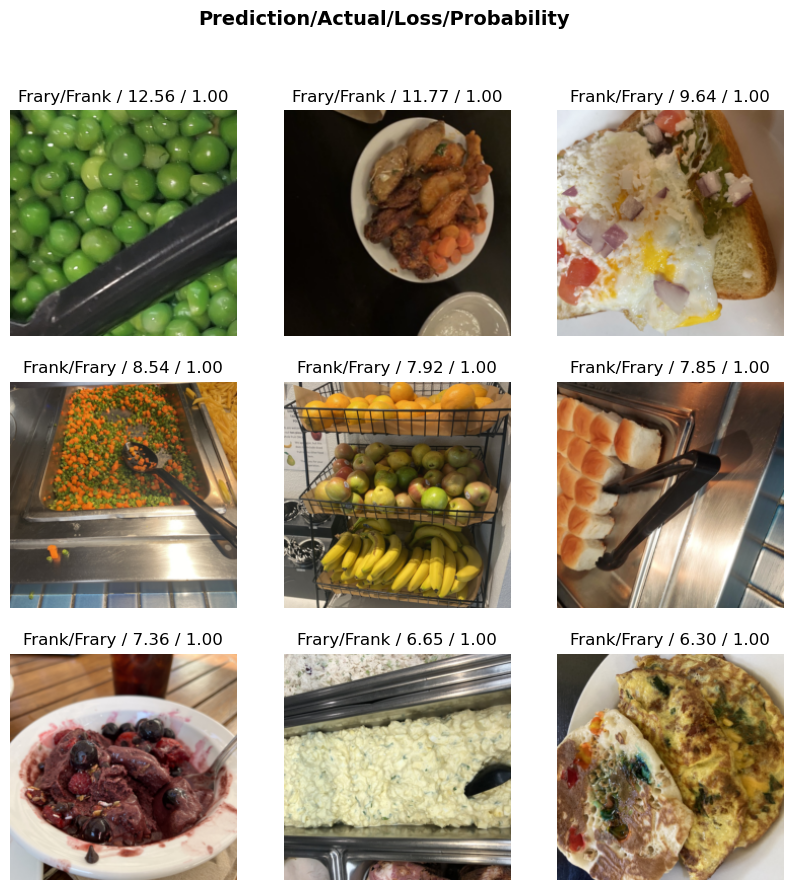

In [11]:
interp.plot_top_losses(9, figsize=(10, 10))

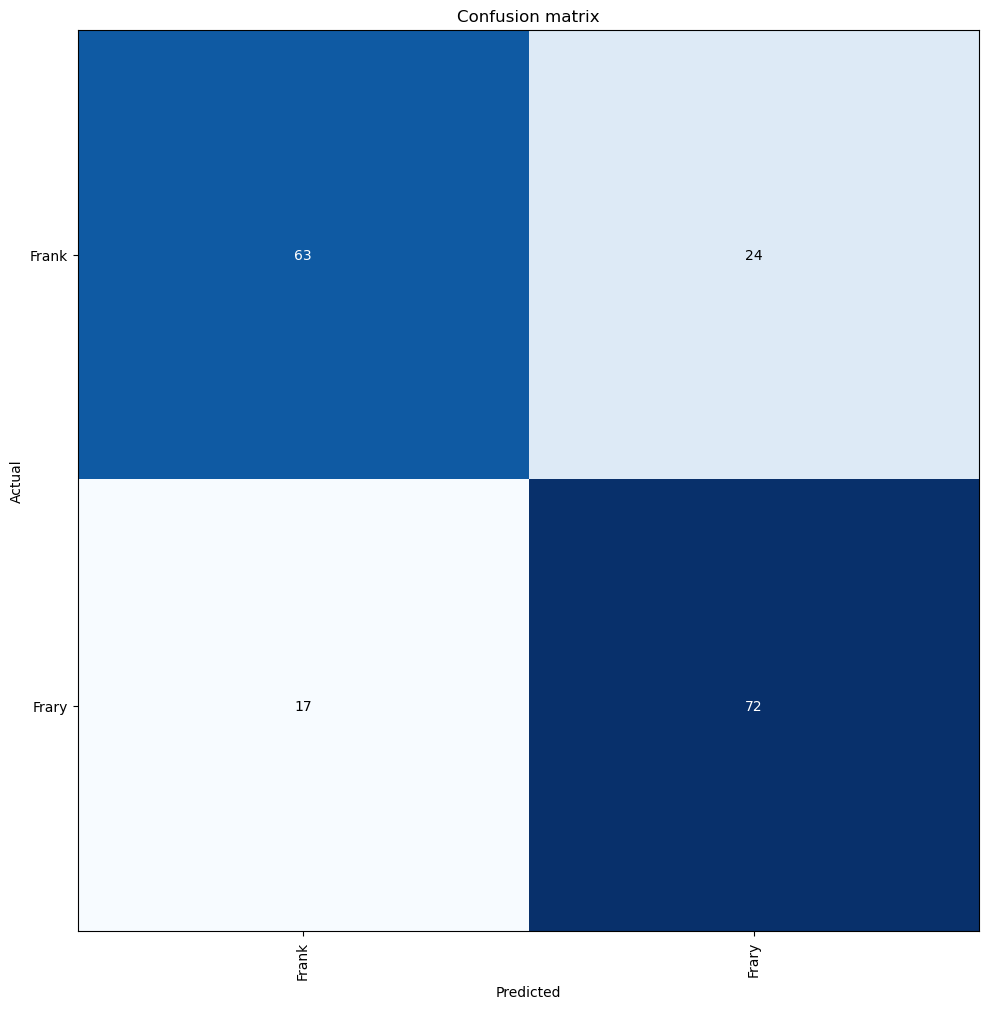

In [12]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [13]:
learn.export("./FrankOrFraryResnet.pkl")

In [14]:
!mv /data/cs152/FrankOrFrary/processed/FrankOrFraryResnet.pkl .

In [15]:
!ls

flagged			  FrankOrFraryResnet.pkl      FrankOrFraryTraining.py
FrankOrFraryGradioApp.py  FrankOrFraryTraining.ipynb  process_images
